[Back to Lecture Overview](Overview.ipynb)

# Database Access
* Author: Johannes Maucher
* Last Update: 13.07.2017
* References: 
    * http://jgardiner.co.uk/blog/read_sql_pandas
    * PostgreSQL Online Manual: [https://www.postgresql.org/docs/8.4/static/queries-table-expressions.html](https://www.postgresql.org/docs/8.4/static/queries-table-expressions.html).
    * SQL Queries in Pandas: http://pandas.pydata.org/pandas-docs/stable/io.html#sql-queries
    * SQLAlchemy documentation: http://docs.sqlalchemy.org/en/latest/intro.html
    * SQLAlchemy tutorial of Python Central: http://pythoncentral.io/introductory-tutorial-python-sqlalchemy/


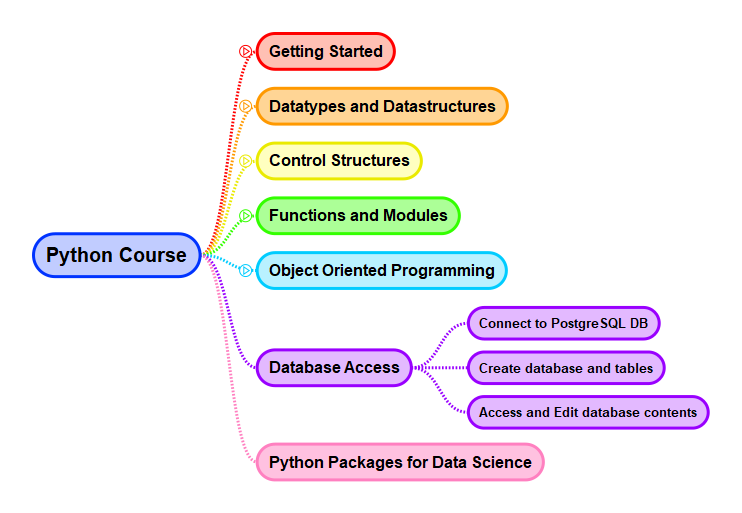

In [1]:
from IPython.display import Image
Image(filename="../../Pics/DS_Python_DataBase_All.png")

## Preliminaries
1. Download and install [PostgreSQL](https://www.postgresql.org/)
2. Verify, that pgAdmin has been installed within the PostgreSQL installation. pgAdmin is an open source administration and development platform for PostgreSQL databases. 
3. In pgAdmin create a new database as described e.g. in https://www.pgadmin.org/docs/pgadmin4/dev/modifying_tables.html.
4. Check if the Python package `psycopg2` is installed. [psycopg2](http://initd.org/psycopg/docs/index.html) is the most popular PostgreSQL database adapter for the Python programming language. For installation type 
`pip install psycopg2`
or
`conda install psycopg2`
into a shell.

In the code below, the name of the database is *dataScienceExp*. Please use your own database- and table-name, instead.

In [2]:
import psycopg2 #provides drivers for PostgreSQL
import numpy as np
import json #required to access json file
import pandas as pd
from sqlalchemy import create_engine

## Connect to Database
The database-connection parameters are defined in a .json file like this [configTemplate.json](configTemplate.json). Replace the placeholders in this file by the connection-parameters of your database and import your personalized configuration file as follows:

In [3]:
with open('configLocalDS2.json') as f:
    conf = json.load(f)

The code above reads the contents of the .json-File into a Python dictionary.

In [9]:
print type(conf)
print "Name of database is: ",conf['database']
print "Name of user is: ",conf['user']

<type 'dict'>
Name of database is:  dataScienceExp
Name of user is:  dataScientist


Next, the information from the `conf`-dictionary is integrated in a string-variable `conn_str`, which is passed to the `connect()`-method of `psycopg2`. This method returns a connection-object to the configured database.

In [10]:
conn_str = "host={} dbname={} user={} password={}".format(conf["host"], conf["database"], conf["user"], conf["passw"])
conn = psycopg2.connect(conn_str)
#conn = psycopg2.connect(host=awsDB,dbname="hrv_web",user=awsUser,password=awsPw)

## Without Pandas

The standard Python way to proceed is to generate a `cursor`-object for the connection. This cursor-object can then be used to execute *SQL*-queries:

In [11]:
cur = conn.cursor()

In [13]:
cur.execute("""SELECT * FROM cartable""")

The result of the SQL-query is saved to a Python list by the following command:

In [14]:
rows=cur.fetchall()
print type(rows)
print len(rows)

<type 'list'>
32


In [15]:
for a in rows[:3]:
    print np.array(a)

['Mazda RX4' Decimal('21.0') Decimal('6') Decimal('160.0') Decimal('110')
 Decimal('3.90') Decimal('2.620') Decimal('16.46') Decimal('0')
 Decimal('1') Decimal('4') Decimal('4')]
['Mazda RX4 Wag' Decimal('21.0') Decimal('6') Decimal('160.0')
 Decimal('110') Decimal('3.90') Decimal('2.875') Decimal('17.02')
 Decimal('0') Decimal('1') Decimal('4') Decimal('4')]
['Datsun 710' Decimal('22.8') Decimal('4') Decimal('108.0') Decimal('93')
 Decimal('3.85') Decimal('2.320') Decimal('18.61') Decimal('1')
 Decimal('1') Decimal('4') Decimal('1')]


In [16]:
print cur.fetchone()

None


In [17]:
cur.execute("""SELECT * FROM cartable""")

In [18]:
print cur.fetchone()

('Mazda RX4', Decimal('21.0'), Decimal('6'), Decimal('160.0'), Decimal('110'), Decimal('3.90'), Decimal('2.620'), Decimal('16.46'), Decimal('0'), Decimal('1'), Decimal('4'), Decimal('4'))


In [19]:
print cur.fetchone()

('Mazda RX4 Wag', Decimal('21.0'), Decimal('6'), Decimal('160.0'), Decimal('110'), Decimal('3.90'), Decimal('2.875'), Decimal('17.02'), Decimal('0'), Decimal('1'), Decimal('4'), Decimal('4'))


In [20]:
print cur.fetchmany(2)

[('Datsun 710', Decimal('22.8'), Decimal('4'), Decimal('108.0'), Decimal('93'), Decimal('3.85'), Decimal('2.320'), Decimal('18.61'), Decimal('1'), Decimal('1'), Decimal('4'), Decimal('1')), ('Hornet 4 Drive', Decimal('21.4'), Decimal('6'), Decimal('258.0'), Decimal('110'), Decimal('3.08'), Decimal('3.215'), Decimal('19.44'), Decimal('1'), Decimal('0'), Decimal('3'), Decimal('1'))]


### Create new table and insert some data
The following SQL statement creates a new table, if it not already exists. The table has three columns `id`, `num` and `data`. The first column is a serial number, which acts as primary key, the second column is an integer and the third a string variable. 

In [21]:
cur.execute("CREATE TABLE IF NOT EXISTS test1 (id serial PRIMARY KEY, num integer, data varchar);")

Insert some data into the table:

In [22]:
cur.execute("INSERT INTO test1 (num, data) VALUES (%s, %s)",(100, "first test entry"))

In [23]:
cur.execute("INSERT INTO test1 (num, data) VALUES (%s, %s)",(200, "second test entry"))

Load the entire table:

In [24]:
cur.execute("SELECT * FROM test1;")

In [25]:
print cur.fetchall()

[(1, 100, 'first test entry'), (2, 200, 'second test entry'), (3, 100, 'first test entry'), (4, 200, 'second test entry'), (5, 100, 'first test entry'), (6, 200, 'second test entry')]


The changes to the databases will only be persistent after the following `commit`-command:

In [26]:
conn.commit()

Close the communication with the database:

In [27]:
cur.close()
conn.close()

## Read entire data into Pandas Dataframe

Provided a connection-object, as returned by `psycopg2.connect()`-method, is available, database-data can easily be imported to Pandas dataframes.

In [30]:
df = pd.read_sql('select * from cartable', con=conn)

In [31]:
print df.shape

(32, 12)


In [32]:
df

,carname,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6.0,160.0,110.0,3.90,2.620,16.46,0.0,1.0,4.0,4.0
1,Mazda RX4 Wag,21.0,6.0,160.0,110.0,3.90,2.875,17.02,0.0,1.0,4.0,4.0
2,Datsun 710,22.8,4.0,108.0,93.0,3.85,2.320,18.61,1.0,1.0,4.0,1.0
3,Hornet 4 Drive,21.4,6.0,258.0,110.0,3.08,3.215,19.44,1.0,0.0,3.0,1.0
4,Hornet Sportabout,18.7,8.0,360.0,175.0,3.15,3.440,17.02,0.0,0.0,3.0,2.0
5,Valiant,18.1,6.0,225.0,105.0,2.76,3.460,20.22,1.0,0.0,3.0,1.0
6,Duster 360,14.3,8.0,360.0,245.0,3.21,3.570,15.84,0.0,0.0,3.0,4.0
7,Merc 240D,24.4,4.0,146.7,62.0,3.69,3.190,20.00,1.0,0.0,4.0,2.0
8,Merc 230,22.8,4.0,140.8,95.0,3.92,3.150,22.90,1.0,0.0,4.0,2.0
9,Merc 280,19.2,6.0,167.6,123.0,3.92,3.440,18.30,1.0,0.0,4.0,4.0


In [28]:
conn.close()

## Using SQLAlchemy  and Pandas
The SQLAlchemy SQL Toolkit and Object Relational Mapper (ORM) is a comprehensive set of tools for working with databases and Python ([SQLAlchemy Overview](http://docs.sqlalchemy.org/en/latest/intro.html)). This [SQLAlchemy Tutorial](http://pythoncentral.io/introductory-tutorial-python-sqlalchemy/) provides a glimpse of ORM in SQLAlchemy.

In this lecture, SQLAlchemy is just used because it provides a  comfortable interface with Pandas dataframes. In particular because of its capability to write Pandas dataframe to database tables. 

For accessing a database with SQLAlchemy first an `engine`-object must be created.

In [33]:
from sqlalchemy import create_engine
engine = create_engine('postgresql://postgres@localhost:5432/dataScienceExp')

### Read entire table

The `engine`-object provides the function `connect()` for connecting to the database. This connection can be passed to the `read_sql_table(datatable,connection)`-function of Pandas, which returns a pandas dataframe containing the data of the specified databasetable.

In [34]:
with engine.connect() as conn, conn.begin():
    data = pd.read_sql_table('cartable',conn)

In [35]:
data

,carname,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6.0,160.0,110.0,3.90,2.620,16.46,0.0,1.0,4.0,4.0
1,Mazda RX4 Wag,21.0,6.0,160.0,110.0,3.90,2.875,17.02,0.0,1.0,4.0,4.0
2,Datsun 710,22.8,4.0,108.0,93.0,3.85,2.320,18.61,1.0,1.0,4.0,1.0
3,Hornet 4 Drive,21.4,6.0,258.0,110.0,3.08,3.215,19.44,1.0,0.0,3.0,1.0
4,Hornet Sportabout,18.7,8.0,360.0,175.0,3.15,3.440,17.02,0.0,0.0,3.0,2.0
5,Valiant,18.1,6.0,225.0,105.0,2.76,3.460,20.22,1.0,0.0,3.0,1.0
6,Duster 360,14.3,8.0,360.0,245.0,3.21,3.570,15.84,0.0,0.0,3.0,4.0
7,Merc 240D,24.4,4.0,146.7,62.0,3.69,3.190,20.00,1.0,0.0,4.0,2.0
8,Merc 230,22.8,4.0,140.8,95.0,3.92,3.150,22.90,1.0,0.0,4.0,2.0
9,Merc 280,19.2,6.0,167.6,123.0,3.92,3.440,18.30,1.0,0.0,4.0,4.0


### SQL-Queries
SQL queries can be realized by writing the SQL statement into a string-variable and passing this string to the Pandas function `read_sql_query()`.

In [36]:
cyl8=pd.read_sql_query("SELECT carname,mpg,cyl,carb FROM cartable WHERE cyl=8 ORDER BY mpg",engine)

In [37]:
cyl8

,carname,mpg,cyl,carb
0,Cadillac Fleetwood,10.4,8.0,4.0
1,Lincoln Continental,10.4,8.0,4.0
2,Camaro Z28,13.3,8.0,4.0
3,Duster 360,14.3,8.0,4.0
4,Chrysler Imperial,14.7,8.0,4.0
5,Maserati Bora,15.0,8.0,8.0
6,Merc 450SLC,15.2,8.0,3.0
7,AMC Javelin,15.2,8.0,2.0
8,Dodge Challenger,15.5,8.0,2.0
9,Ford Pantera L,15.8,8.0,4.0


### Write Pandas dataframe into database
The following code cells demonstrate how 
* data can be imported from a .csv-file into a Pandas dataframe
* the Pandas dataframe is written into a databasetable.
* if the table not already exists, it will be created first.


Read data from .csv - file into Pandas dataframe:

In [38]:
insuranceDF=pd.read_csv("../../R/Lecture/data/insurance.csv",sep=",",header=0,index_col=False)

In [39]:
insuranceDF.shape

(1338, 7)

In [40]:
insuranceDF.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Write Pandas dataframe into a new table in PostgreSQL DB. 

In [41]:
if not engine.has_table("insurancetable"):
    insuranceDF.to_sql(name='insurancetable',index=True, index_label='index',con=engine)
else:
    print "table already exists"

table already exists


Check if data of the new table can be accessed:

In [42]:
with engine.connect() as conn, conn.begin():
    data = pd.read_sql_table('insurancetable',conn)

In [43]:
data.head()

,index,age,sex,bmi,children,smoker,region,charges
0,0,19,female,27.900,0,yes,southwest,16884.92400
1,1,18,male,33.770,1,no,southeast,1725.55230
2,2,28,male,33.000,3,no,southeast,4449.46200
3,3,33,male,22.705,0,no,northwest,21984.47061
4,4,32,male,28.880,0,no,northwest,3866.85520


In [44]:
child3=pd.read_sql_query("SELECT * FROM insurancetable WHERE children > 3 ORDER BY children",engine)

In [43]:
child3

,index,age,sex,bmi,children,smoker,region,charges
0,344,49,female,41.470,4,no,southeast,10977.20630
1,390,48,male,35.625,4,no,northeast,10736.87075
2,83,48,female,41.230,4,no,northwest,11033.66170
3,165,47,male,28.215,4,no,northeast,10407.08585
4,1012,61,female,33.330,4,no,southeast,36580.28216
5,1064,29,female,25.600,4,no,southwest,5708.86700
6,61,25,male,33.660,4,no,southeast,4504.66240
7,1094,50,female,33.700,4,no,southwest,11299.34300
8,1095,18,female,31.350,4,no,northeast,4561.18850
9,450,39,male,29.600,4,no,southwest,7512.26700


## Exercises
[Exercise on Database Access in Python](../Assignments/Ass07DataBase.ipynb)